In [244]:
%pip install nltk
%pip install openpyxl
%pip install contractions
%pip install inflect
%pip install spacy
%pip install gensim
%python -m spacy download es_core_news_md

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [245]:
import numpy as np
import pandas as pd
import nltk
import openpyxl

import re, string, unicodedata
import contractions
import inflect


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin

In [246]:
import spacy
nlp = spacy.load("es_core_news_md")  # Cargar el modelo de spaCy en español

In [247]:
import warnings
warnings.filterwarnings("ignore")

In [248]:
# Configuring pandas to show all cell content
pd.set_option("display.max_colwidth", None)

In [249]:
# Descarga los datos para el idioma español
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger") 

stop_words = stopwords.words("spanish")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [250]:
stop_words

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

In [251]:
# Uso de la libreria pandas para la lectura de archivos
data = pd.read_excel('./data/cat_345.xlsx')
# Asignación a una nueva variable de los datos leidos
df_obj=data


In [252]:
df_obj.head()

,Textos_espanol,sdg
0,"Por ejemplo, el nÃºmero de consultas externas de especialistas es de 319 por cada mil derechohabientes en el SP, en comparaciÃ³n con 338 y 620 por cada mil derechohabientes en el IMSS y el ISSSTE, respectivamente. Si bien algunas de estas diferencias pueden reflejar una necesidad desigual (como la poblaciÃ³n ligeramente mayor del ISSSTE), otras no pueden justificarse de esta manera. El nÃºmero de recetas que no pudieron ser surtidas en su totalidad por un farmacÃ©utico debido a la falta de existencias es de 33% dentro del SP en comparaciÃ³n con 14% dentro del IMSS segÃºn los datos de la encuesta (aunque las propias cifras de los institutos de la SS sugieren tasas mÃ¡s altas de recetas surtidas). Ambas cifras se encuentran entre las mÃ¡s altas de la OCDE. El gasto de bolsillo no se ha reducido significativamente en la última década, a pesar de los esfuerzos para lograr la cobertura sanitaria universal a través de la reforma del SP.",3
1,"En 2007, el gobierno central financió directamente solo el 0,3% del gasto total en salud, pero realizó transferencias específicas para el gasto en salud que ascendieron a otro 5,6% del gasto total. La mayor parte del gasto presupuestario en salud lo realizan los gobiernos de los condados. Por lo tanto, los condados pobres solo pueden ofrecer un bajo nivel de atención a la población local. El gobierno provincial proporciona subsidios del lado de la oferta a los hospitales.",3
2,"Claramente, hay muchos otros factores en juego, en particular, una variedad de barreras y determinantes sociales. Estos pueden estar relacionados con el género, la clase, la etnia, la casta, el idioma y la religión, y surgen de estructuras, normas y procesos sociales arraigados que aceptan e incluso fomentan distribuciones injustas de la riqueza y los recursos sociales. Por ejemplo, las personas que viven con el VIH y algunas otras enfermedades crónicas enfrentan altos niveles de estigma y discriminación que dificultan su acceso a pruebas médicas, tratamiento, atención y apoyo. Por lo tanto, los gobiernos que buscan mejorar los estándares de salud querrán mejorar la condición de la mujer, brindar servicios de salud reproductiva efectivos, implementar programas integrales de lactancia materna en línea con las recomendaciones actuales y aumentar las presiones comunitarias contra el aborto selectivo por sexo. Las personas pobres, que carecen de educación e información, o de fondos para opciones más saludables, son más vulnerables al impacto de las ENT que los ricos y es probable que mueran antes. Directa e indirectamente, las ENT tendrán impactos de gran alcance en el progreso hacia los ODM.",3
3,"Por ejemplo, el estado australiano de Victoria creó una agencia de promoción de la salud financiada con los impuestos sobre el tabaco, y varios estados de EE.UU. (California, Massachusetts, Arizona y Oregón) han destinado parte de los ingresos procedentes de los impuestos especiales sobre el tabaco a actividades de educación y control del tabaco, mientras que en Nueva Jersey, Ohio y Texas los ingresos procedentes del alcohol se utilizan para programas de educación y prevención relacionados con el alcohol (Sassi et al., 2004), Los impuestos locales pueden ser una fuente importante de ingresos, sobre todo en los sistemas sanitarios descentralizados (por ejemplo, Dinamarca, Finlandia, Italia y Suecia)17 . Además, el nivel de los impuestos locales puede fijarse en función de las preferencias locales sobre el nivel y la calidad de los servicios médicos. Sin embargo, en ausencia de un mecanismo de transferencia ajustado al riesgo y gestionado centralmente, la descentralización reduce la mancomunación de riesgos y podría dar lugar a mayores disparidades sanitarias interregionales.",3
4,"El consumo anual de alcohol se estima en 15,7 litros al año para los hombres, más de un 50% por encima de la media de la OCDE (10,4) (Sistema mundial de información sobre alcohol y salud de la OMS), lo que puede ayudar a explicar la

In [253]:
df_obj["sdg"].value_counts(dropna=False, normalize=True)

sdg
3    0.333333
4    0.333333
5    0.333333
Name: proportion, dtype: float64

In [254]:
# The param 'stratify' is useful to guarantee label proportions on train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_obj[["Textos_espanol"]], df_obj["sdg"], test_size=0.3, stratify=df_obj["sdg"], random_state=1)

In [255]:
X_train.shape, X_test.shape

((2100, 1), (900, 1))

In [256]:
pd.Series(y_train).value_counts(normalize=True)

sdg
4    0.333333
3    0.333333
5    0.333333
Name: proportion, dtype: float64

In [257]:
pd.Series(y_test).value_counts(normalize=True)

sdg
3    0.333333
4    0.333333
5    0.333333
Name: proportion, dtype: float64

### Vectorizacion de textos

In [258]:
bow = CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [259]:
X_bow = bow.fit_transform(X_train["Textos_espanol"])

In [260]:
print("Vocabulary size:", len(bow.vocabulary_))

Vocabulary size: 15550


In [261]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [262]:
X_tfidf = tfidf.fit_transform(X_train["Textos_espanol"])

In [263]:
print("Vocabulary size:", len(tfidf.vocabulary_))

Vocabulary size: 15550


# BoW:

In [264]:
bow_model = RandomForestClassifier(random_state=2)

In [265]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<Axes: >

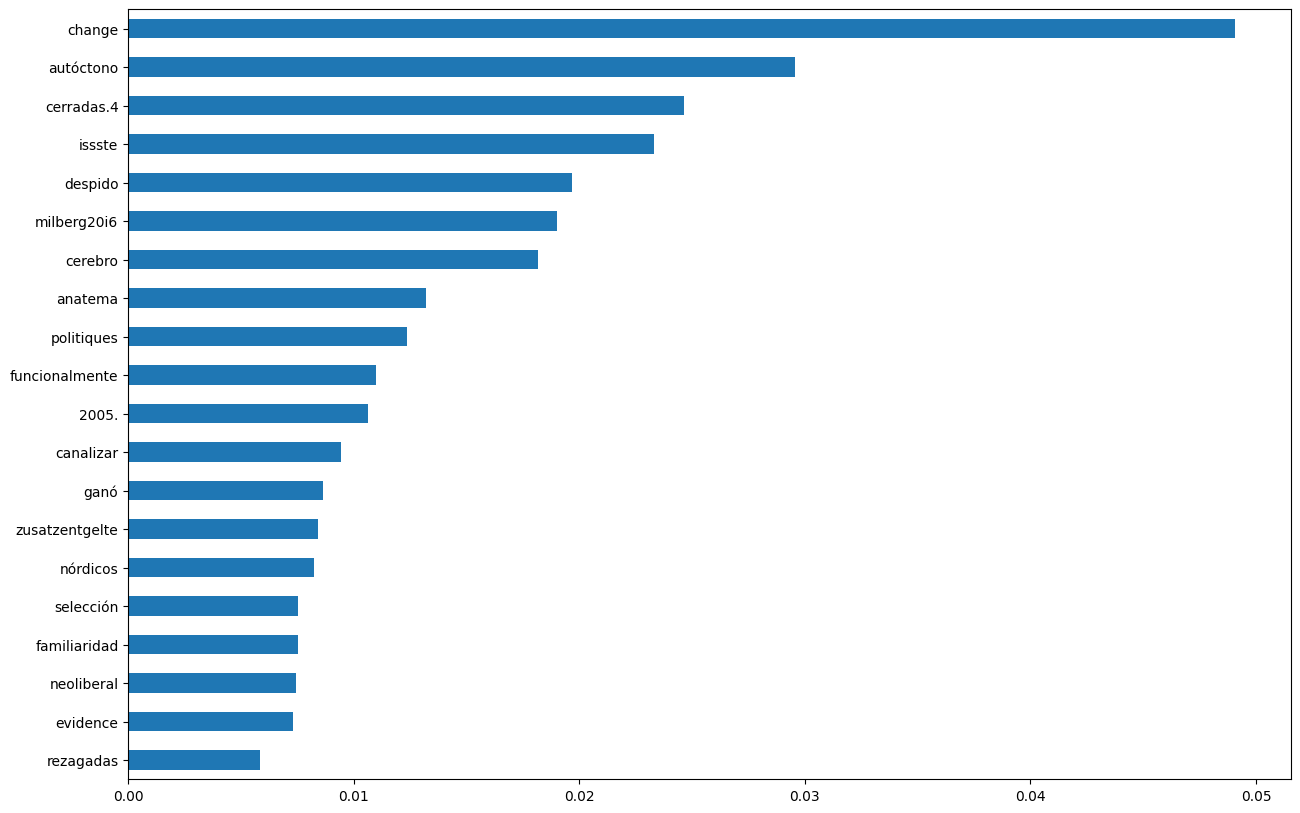

In [266]:
# Feature importance in tree models is an indicator on how relevant is a feature for taking the decision by the model
pd.Series(bow_model.feature_importances_, index=bow.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [267]:
bow_estimators = bow_model.estimators_
print("Number of trees:", len(bow_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 100.39


In [268]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test["Textos_espanol"]))

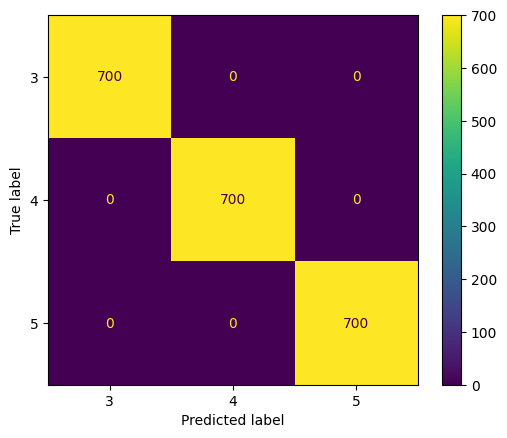

In [269]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

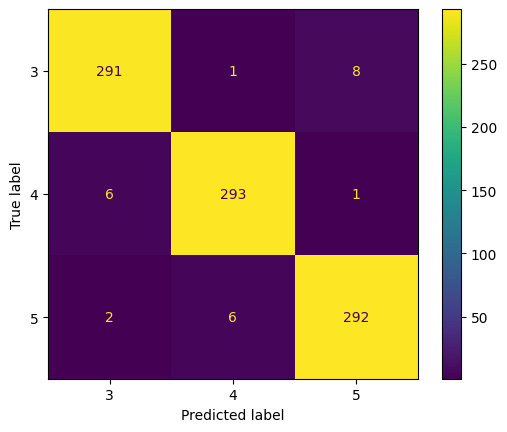

In [270]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [271]:
print("Precision:", precision_score(y_train, y_train_bow_predict, average='weighted'))
print("Recall:", recall_score(y_train, y_train_bow_predict, average='weighted'))
print("F1:", f1_score(y_train, y_train_bow_predict, average='weighted'))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [272]:
print("Precision:", precision_score(y_test, y_test_bow_predict,average='weighted'))
print("Recall:", recall_score(y_test, y_test_bow_predict,average='weighted'))
print("F1:", f1_score(y_test, y_test_bow_predict,average='weighted'))

Precision: 0.9733368271993146
Recall: 0.9733333333333334
F1: 0.9733332808640519


### Doc2Vec

In [273]:
def tokenize_and_tag(texts):
    tagged_data = []
    for i, text in enumerate(texts):
        words = word_tokenize(text)
        tags = [i]
        tagged_data.append(TaggedDocument(words=words, tags=tags))
    return tagged_data

# Tokeniza y etiqueta los textos de entrenamiento y prueba
tagged_data_train = tokenize_and_tag(X_train["Textos_espanol"])
tagged_data_test = tokenize_and_tag(X_test["Textos_espanol"])




In [274]:
# Crea un modelo Doc2Vec
doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)

# Construye el vocabulario
doc2vec_model.build_vocab(tagged_data_train)

# Entrena el modelo Doc2Vec
doc2vec_model.train(tagged_data_train, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)




In [275]:
# Vectoriza los textos de entrenamiento y prueba
X_train['doc2vec_features'] = [doc2vec_model.infer_vector(doc.words) for doc in tagged_data_train]
X_test['doc2vec_features'] = [doc2vec_model.infer_vector(doc.words) for doc in tagged_data_test]


In [276]:

# Modelo con Doc2Vec
doc2vec_model = RandomForestClassifier(random_state=5)
doc2vec_model.fit(list(X_train['doc2vec_features']), y_train)
y_train_doc2vec_predict = doc2vec_model.predict(list(X_train['doc2vec_features']))
y_test_doc2vec_predict = doc2vec_model.predict(list(X_test['doc2vec_features']))


In [277]:
precision_doc2vec = precision_score(y_test, y_test_doc2vec_predict, average='weighted')
recall_doc2vec = recall_score(y_test, y_test_doc2vec_predict, average='weighted')
f1_doc2vec = f1_score(y_test, y_test_doc2vec_predict, average='weighted')

print("Precision:", precision_doc2vec)
print("Recall:", recall_doc2vec)
print("F1:", f1_doc2vec)

Precision: 0.8924137311690353
Recall: 0.8922222222222222
F1: 0.8922726435164245


## GloVe

In [278]:
def glove_vectorize(text):
    doc = nlp(text)
    return doc.vector

In [279]:
# Agrega una nueva columna de características a tus datos
X_train['glove_features'] = X_train["Textos_espanol"].apply(glove_vectorize)
X_test['glove_features'] = X_test["Textos_espanol"].apply(glove_vectorize)

In [280]:
# Crear un modelo RandomForestClassifier para GloVe
glove_model = RandomForestClassifier(random_state=4)
glove_model.fit(list(X_train['glove_features']), y_train)

RandomForestClassifier(random_state=4)

In [281]:
# Predecir con el modelo de GloVe
y_train_glove_predict = glove_model.predict(list(X_train['glove_features']))
y_test_glove_predict = glove_model.predict(list(X_test['glove_features']))

In [282]:
# Calcula métricas para el modelo de GloVe
precision_glove = precision_score(y_test, y_test_glove_predict, average='weighted')
recall_glove = recall_score(y_test, y_test_glove_predict, average='weighted')
f1_glove = f1_score(y_test, y_test_glove_predict, average='weighted')

print("Precision:", precision_glove)
print("Recall:", recall_glove)
print("F1:", f1_glove)

Precision: 0.8278492977291264
Recall: 0.8266666666666667
F1: 0.8266073313241903


##  Modelo con TF-IDF

In [283]:
tfidf_model = RandomForestClassifier(random_state=3)

In [284]:
tfidf_model.fit(X_tfidf, y_train)

RandomForestClassifier(random_state=3)

<Axes: >

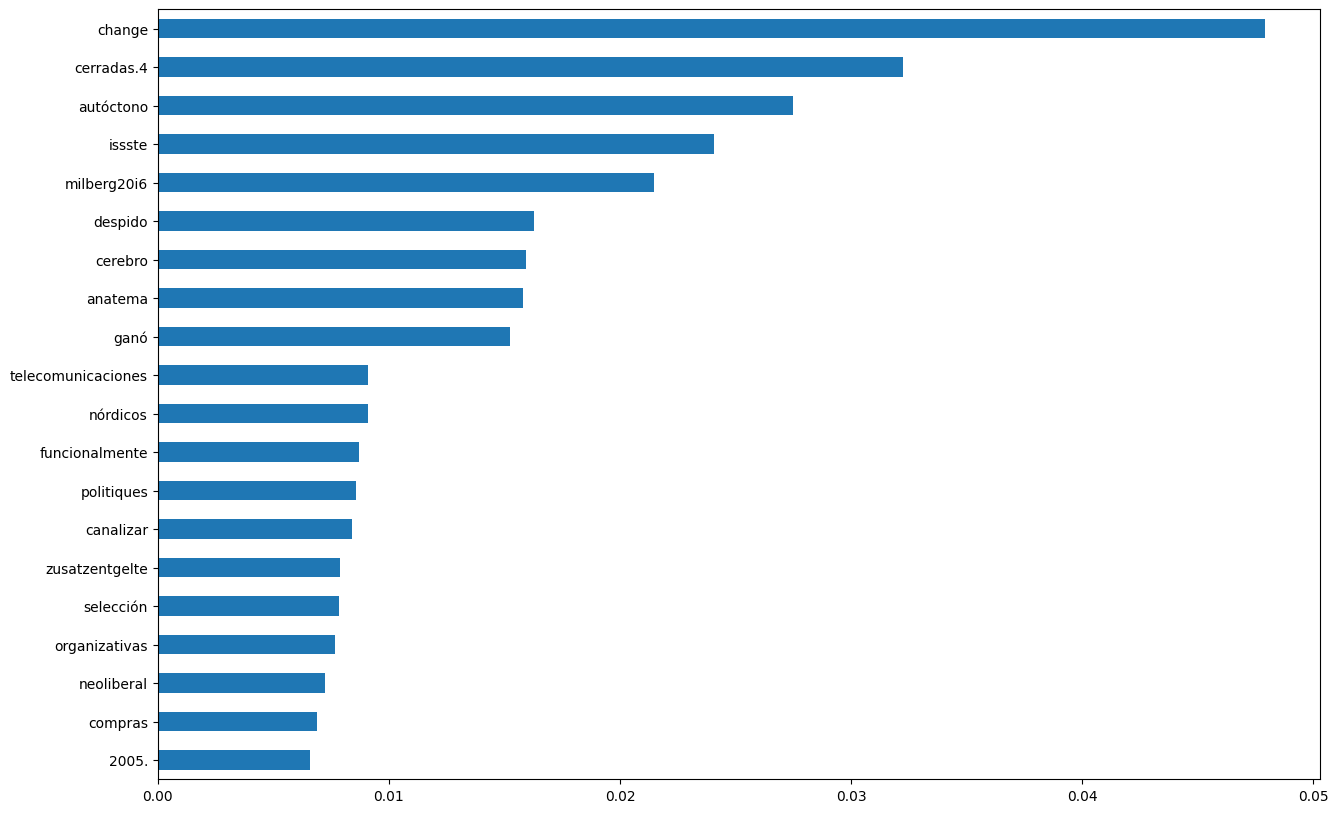

In [285]:
pd.Series(tfidf_model.feature_importances_, index=tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [286]:
tfidf_estimators = tfidf_model.estimators_
print("Number of trees:", len(tfidf_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 96.69


In [287]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test["Textos_espanol"]))

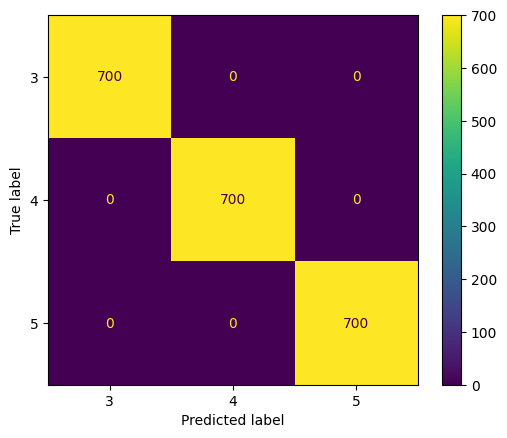

In [288]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

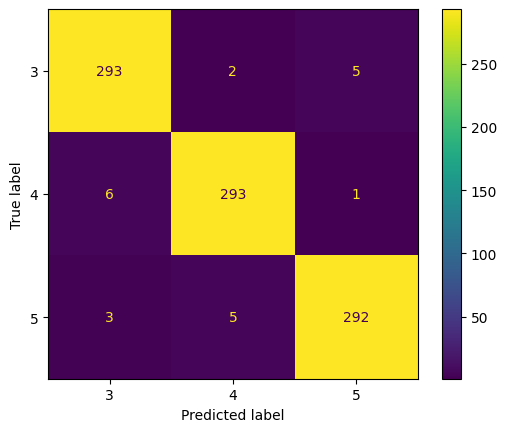

In [289]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [290]:
print("Precision:", precision_score(y_train, y_train_tfidf_predict,average='weighted'))
print("Recall:", recall_score(y_train, y_train_tfidf_predict,average='weighted'))
print("F1:", f1_score(y_train, y_train_tfidf_predict,average='weighted'))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [291]:
print("Precision:", precision_score(y_test, y_test_tfidf_predict,average='weighted'))
print("Recall:", recall_score(y_test, y_test_tfidf_predict,average='weighted'))
print("F1:", f1_score(y_test, y_test_tfidf_predict,average='weighted'))

Precision: 0.9755770379918121
Recall: 0.9755555555555555
F1: 0.9755590741131692


## Model Selection

In [292]:
pipeline = Pipeline(steps = [
    ("vectorizer", CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)),
    ("classifier", RandomForestClassifier(random_state=4))
])

In [293]:
param_grid = {
    "vectorizer": [CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words), TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words)],
    "vectorizer__lowercase": [True, False],
    "classifier__n_estimators": [50, 100],
    "classifier__criterion": ['gini', 'entropy'],
    "classifier__max_depth": [25, 50, 75, 100]
}

In [294]:
search = RandomizedSearchCV(pipeline, param_grid, n_iter=7, scoring=["precision", "recall", "f1"], refit="f1", cv=10, return_train_score=True, verbose=1, random_state=5)

In [295]:
search.fit(X_train["Textos_espanol"], y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('vectorizer',
                                              CountVectorizer(stop_words=['de',
                                                                          'la',
                                                                          'que',
                                                                          'el',
                                                                          'en',
                                                                          'y',
                                                                          'a',
                                                                          'los',
                                                                          'del',
                                                                          'se',
                                                                          'las',
                                                                          'por',
                                                                          'un',
                                                                          'para',
                                                                          'con',
                                                                          'no',
                                                                          'una',
                                                                          'su',
                                                                          'al',
                                                                          'lo',
                                                                          'como',
                                                                          'más',
                                                                          'pero',
                                                                          'sus',
                                                                          'le',
                                                                          'ya',
                                                                          'o',
                                                                          'este',
                                                                          'sí',
                                                                          'porque', ...],
                                                              tokenizer=<function word_tokenize at 0x000001CF9C4D3F60>)),
                                             ('classifier',
                                              RandomForestCl...
                                                                                   'que',
                                                                                   'el',
                                                                                   'en',
                                                                                   'y',
                                                                                   'a',
                                                                                   'los',
                                                                                   'del',
                                                                                   'se',
                                                                                   'las',
                                                                                   'por',
                                                                                   'un',
                                                                                   'para',
                                                                                   'con',
                                                                                 

In [296]:
search.best_params_

{'vectorizer__lowercase': False,
 'vectorizer': CountVectorizer(lowercase=False,
                 stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                             'del', 'se', 'las', 'por', 'un', 'para', 'con',
                             'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                             'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                             'porque', ...],
                 tokenizer=<function word_tokenize at 0x000001CF9C4D3F60>),
 'classifier__n_estimators': 100,
 'classifier__max_depth': 100,
 'classifier__criterion': 'gini'}

In [297]:
search.best_score_

nan

In [298]:
y_train_search_predict = search.best_estimator_.predict(X_train["Textos_espanol"])
y_test_search_predict = search.best_estimator_.predict(X_test["Textos_espanol"])

In [299]:
print("Precision:", precision_score(y_train, y_train_search_predict,average='weighted'))
print("Recall:", recall_score(y_train, y_train_search_predict,average='weighted'))
print("F1:", f1_score(y_train, y_train_search_predict,average='weighted'))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [300]:
print("Precision:", precision_score(y_test, y_test_search_predict,average='weighted'))
print("Recall:", recall_score(y_test, y_test_search_predict,average='weighted'))
print("F1:", f1_score(y_test, y_test_search_predict,average='weighted'))

Precision: 0.9778273283880844
Recall: 0.9777777777777777
F1: 0.9777809770611384


### Limpieza de datos


In [301]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words = []
    for word in words:
        new_words.append(word.lower())
    return new_words
    """Convert all characters to lowercase from list of tokenized words"""

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    stop_words = set(stopwords.words("spanish"))
    new_words = [word for word in words if word not in stop_words]
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [302]:
df_obj['Textos_espanol'] = df_obj['Textos_espanol'].apply(contractions.fix) #Aplica la corrección de las contracciones
df_obj.head()

,Textos_espanol,sdg
0,"Por ejemplo, el nÃºmero de consultas externas de especialistas es de 319 por cada mil derechohabientes en el SP, en comparaciÃ³n con 338 y 620 por cada mil derechohabientes en el IMSS y el ISSSTE, respectivamente. Si bien algunas de estas diferencias pueden reflejar una necesidad desigual (como la poblaciÃ³n ligeramente mayor del ISSSTE), otras no pueden justificarse de esta manera. El nÃºmero de recetas que no pudieron ser surtidas en su totalidad por un farmacÃ©utico debido a la falta de existencias es de 33% dentro del SP en comparaciÃ³n con 14% dentro del IMSS segÃºn los datos de la encuesta (aunque las propias cifras de los institutos de la SS sugieren tasas mÃ¡s altas de recetas surtidas). Ambas cifras se encuentran entre las mÃ¡s altas de la OCDE. El gasto de bolsillo no se ha reducido significativamente en la última década, a pesar de los esfuerzos para lograr la cobertura sanitaria universal a través de la reforma del SP.",3
1,"En 2007, el gobierno central financió directamente solo el 0,3% del gasto total en salud, pero realizó transferencias específicas para el gasto en salud que ascendieron a otro 5,6% del gasto total. La mayor parte del gasto presupuestario en salud lo realizan los gobiernos de los condados. Por lo tanto, los condados pobres solo pueden ofrecer un bajo nivel de atención a la población local. El gobierno provincial proporciona subsidios del lado de la oferta a los hospitales.",3
2,"Claramente, hay muchos otros factores en juego, en particular, una variedad de barreras y determinantes sociales. Estos pueden estar relacionados con el género, la clase, la etnia, la casta, el idioma y la religión, y surgen de estructuras, normas y procesos sociales arraigados que aceptan e incluso fomentan distribuciones injustas de la riqueza y los recursos sociales. Por ejemplo, las personas que viven con el VIH y algunas otras enfermedades crónicas enfrentan altos niveles de estigma y discriminación que dificultan su acceso a pruebas médicas, tratamiento, atención y apoyo. Por lo tanto, los gobiernos que buscan mejorar los estándares de salud querrán mejorar la condición de la mujer, brindar servicios de salud reproductiva efectivos, implementar programas integrales de lactancia materna en línea con las recomendaciones actuales y aumentar las presiones comunitarias contra el aborto selectivo por sexo. Las personas pobres, que carecen de educación e información, o de fondos para opciones más saludables, son más vulnerables al impacto de las ENT que los ricos y es probable que mueran antes. Directa e indirectamente, las ENT tendrán impactos de gran alcance en el progreso hacia los ODM.",3
3,"Por ejemplo, el estado australiano de Victoria creó una agencia de promoción de la salud financiada con los impuestos sobre el tabaco, y varios estados de EE.UU. (California, Massachusetts, Arizona y Oregón) han destinado parte de los ingresos procedentes de los impuestos especiales sobre el tabaco a actividades de educación y control del tabaco, mientras que en Nueva Jersey, Ohio y Texas los ingresos procedentes del alcohol se utilizan para programas de educación y prevención relacionados con el alcohol (Sassi et al., 2004), Los impuestos locales pueden ser una fuente importante de ingresos, sobre todo en los sistemas sanitarios descentralizados (por ejemplo, Dinamarca, Finlandia, Italia y Suecia)17 . Además, el nivel de los impuestos locales puede fijarse en función de las preferencias locales sobre el nivel y la calidad de los servicios médicos. Sin embargo, en ausencia de un mecanismo de transferencia ajustado al riesgo y gestionado centralmente, la descentralización reduce la mancomunación de riesgos y podría dar lugar a mayores disparidades sanitarias interregionales.",3
4,"El consumo anual de alcohol se estima en 15,7 litros al año para los hombres, más de un 50% por encima de la media de la OCDE (10,4) (Sistema mundial de información sobre alcohol y salud de la OMS), lo que puede ayudar a explicar la

In [303]:
df_obj['Textos_Tokenizados'] = df_obj['Textos_espanol'].apply(contractions.fix)  # Aplica la corrección de las contracciones
df_obj['Textos_Tokenizados'] = df_obj['Textos_espanol'].apply(preprocessing)  # Aplica la eliminación del ruido
df_obj['Textos_Tokenizados'] = df_obj['Textos_espanol'].apply(word_tokenize)  # Tokeniza las palabras



In [304]:
df_obj.head()

,Textos_espanol,sdg,Textos_Tokenizados
0,"Por ejemplo, el nÃºmero de consultas externas de especialistas es de 319 por cada mil derechohabientes en el SP, en comparaciÃ³n con 338 y 620 por cada mil derechohabientes en el IMSS y el ISSSTE, respectivamente. Si bien algunas de estas diferencias pueden reflejar una necesidad desigual (como la poblaciÃ³n ligeramente mayor del ISSSTE), otras no pueden justificarse de esta manera. El nÃºmero de recetas que no pudieron ser surtidas en su totalidad por un farmacÃ©utico debido a la falta de existencias es de 33% dentro del SP en comparaciÃ³n con 14% dentro del IMSS segÃºn los datos de la encuesta (aunque las propias cifras de los institutos de la SS sugieren tasas mÃ¡s altas de recetas surtidas). Ambas cifras se encuentran entre las mÃ¡s altas de la OCDE. El gasto de bolsillo no se ha reducido significativamente en la última década, a pesar de los esfuerzos para lograr la cobertura sanitaria universal a través de la reforma del SP.",3,"[Por, ejemplo, ,, el, nÃºmero, de, consultas, externas, de, especialistas, es, de, 319, por, cada, mil, derechohabientes, en, el, SP, ,, en, comparaciÃ³n, con, 338, y, 620, por, cada, mil, derechohabientes, en, el, IMSS, y, el, ISSSTE, ,, respectivamente, ., Si, bien, algunas, de, estas, diferencias, pueden, reflejar, una, necesidad, desigual, (, como, la, poblaciÃ³n, ligeramente, mayor, del, ISSSTE, ), ,, otras, no, pueden, justificarse, de, esta, manera, ., El, nÃºmero, de, recetas, que, no, pudieron, ser, surtidas, en, su, totalidad, por, un, farmacÃ©utico, debido, a, la, falta, de, existencias, es, de, 33, %, dentro, del, SP, en, comparaciÃ³n, con, ...]"
1,"En 2007, el gobierno central financió directamente solo el 0,3% del gasto total en salud, pero realizó transferencias específicas para el gasto en salud que ascendieron a otro 5,6% del gasto total. La mayor parte del gasto presupuestario en salud lo realizan los gobiernos de los condados. Por lo tanto, los condados pobres solo pueden ofrecer un bajo nivel de atención a la población local. El gobierno provincial proporciona subsidios del lado de la oferta a los hospitales.",3,"[En, 2007, ,, el, gobierno, central, financió, directamente, solo, el, 0,3, %, del, gasto, total, en, salud, ,, pero, realizó, transferencias, específicas, para, el, gasto, en, salud, que, ascendieron, a, otro, 5,6, %, del, gasto, total, ., La, mayor, parte, del, gasto, presupuestario, en, salud, lo, realizan, los, gobiernos, de, los, condados, ., Por, lo, tanto, ,, los, condados, pobres, solo, pueden, ofrecer, un, bajo, nivel, de, atención, a, la, población, local, ., El, gobierno, provincial, proporciona, subsidios, del, lado, de, la, oferta, a, los, hospitales, .]"
2,"Claramente, hay muchos otros factores en juego, en particular, una variedad de barreras y determinantes sociales. Estos pueden estar relacionados con el género, la clase, la etnia, la casta, el idioma y la religión, y surgen de estructuras, normas y procesos sociales arraigados que aceptan e incluso fomentan distribuciones injustas de la riqueza y los recursos sociales. Por ejemplo, las personas que viven con el VIH y algunas otras enfermedades crónicas enfrentan altos niveles de estigma y discriminación que dificultan su acceso a pruebas médicas, tratamiento, atención y apoyo. Por lo tanto, los gobiernos que buscan mejorar los estándares de salud querrán mejorar la condición de la mujer, brindar servicios de salud reproductiva efectivos, implementar programas integrales de lactancia materna en línea con las recomendaciones actuales y aumentar las presiones comunitarias contra el aborto selectivo por sexo. Las personas pobres, que carecen de educación e información, o de fondos para opciones más saludables, son más vulnerables al impacto de las ENT que los ricos y es probable que mueran antes. Directa e indirectamente, las ENT tendrán impactos de gran alcance en el progreso hacia los ODM.",3,"[Claramente, ,, hay, muchos, otros, factores, en, juego, ,, en, part

In [305]:
df_obj["Textos_Tokenizados"].sample(15)

2768                                                                                                   [Es, cierto, que, muchos, de, los, temas, relacionados, con, el, género, son, de, naturaleza, cultural, ,, cualitativa, y, sociológica, ,, sin, embargo, ,, su, impacto, se, puede, ver, y, observar, espacialmente, ,, y, hasta, cierto, punto, se, puede, medir, cuantitativamente, ., Para, poder, identificar, los, problemas, asociados, con, el, sesgo, de, género, ,, es, fundamental, desarrollar, estadísticas, integrales, ., La, auditoría, de, género, se, puede, definir, como, el, proceso, mediante, el, cual, se, logra, la, incorporación, de, la, perspectiva, de, género, ,, lo, que, implica, establecer, indicadores, y, estándares, ,, y, verificar, productos, ,, políticas, y, prioridades, (, Greed, ,, ...]
2648                                                                                                                                                                                       

In [306]:
# Cargar el lematizador de palabras en inglés
wordnet_lemmatizer = WordNetLemmatizer()

# Cargar el extractor de raíces (stemmer) de Lancaster para el inglés
lancaster_stemmer = LancasterStemmer()

In [307]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stems = [lancaster_stemmer.stem(word) for word in words]
    return stems
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmas = [wordnet_lemmatizer.lemmatize(word) for word in words]
    return lemmas
def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

df_obj['Textos_Tokenizados'] = df_obj['Textos_Tokenizados'].apply(stem_and_lemmatize)
df_obj.head()

,Textos_espanol,sdg,Textos_Tokenizados
0,"Por ejemplo, el nÃºmero de consultas externas de especialistas es de 319 por cada mil derechohabientes en el SP, en comparaciÃ³n con 338 y 620 por cada mil derechohabientes en el IMSS y el ISSSTE, respectivamente. Si bien algunas de estas diferencias pueden reflejar una necesidad desigual (como la poblaciÃ³n ligeramente mayor del ISSSTE), otras no pueden justificarse de esta manera. El nÃºmero de recetas que no pudieron ser surtidas en su totalidad por un farmacÃ©utico debido a la falta de existencias es de 33% dentro del SP en comparaciÃ³n con 14% dentro del IMSS segÃºn los datos de la encuesta (aunque las propias cifras de los institutos de la SS sugieren tasas mÃ¡s altas de recetas surtidas). Ambas cifras se encuentran entre las mÃ¡s altas de la OCDE. El gasto de bolsillo no se ha reducido significativamente en la última década, a pesar de los esfuerzos para lograr la cobertura sanitaria universal a través de la reforma del SP.",3,"[por, ejemplo, ,, el, nãºmero, de, consulta, externa, de, especialista, es, de, 319, por, cad, mil, derechohaby, en, el, sp, ,, en, comparaciã³n, con, 338, y, 620, por, cad, mil, derechohaby, en, el, imss, y, el, issst, ,, respectiva, ., si, bien, alguna, de, esta, diferencia, pued, reflej, un, necesidad, desig, (, como, la, poblaciã³n, ligera, may, del, issst, ), ,, otra, no, pued, justificars, de, est, maner, ., el, nãºmero, de, receta, que, no, pudieron, ser, surtida, en, su, totalidad, por, un, farmacã©utico, debido, a, la, falt, de, existencia, es, de, 33, %, dentro, del, sp, en, comparaciã³n, con, ...]"
1,"En 2007, el gobierno central financió directamente solo el 0,3% del gasto total en salud, pero realizó transferencias específicas para el gasto en salud que ascendieron a otro 5,6% del gasto total. La mayor parte del gasto presupuestario en salud lo realizan los gobiernos de los condados. Por lo tanto, los condados pobres solo pueden ofrecer un bajo nivel de atención a la población local. El gobierno provincial proporciona subsidios del lado de la oferta a los hospitales.",3,"[en, 2007, ,, el, gobierno, cent, financió, directa, solo, el, 0,3, %, del, gasto, tot, en, salud, ,, pero, realizó, transferencia, específica, par, el, gasto, en, salud, que, ascendieron, a, otro, 5,6, %, del, gasto, tot, ., la, may, part, del, gasto, presupuestario, en, salud, lo, real, los, gobierno, de, los, condado, ., por, lo, tanto, ,, los, condado, pobr, solo, pued, ofrec, un, bajo, nivel, de, atención, a, la, población, loc, ., el, gobierno, provint, proporcion, subsidio, del, lado, de, la, ofert, a, los, hospit, ., En, 2007, ,, el, gobierno, central, financió, directamente, solo, el, 0,3, %, del, ...]"
2,"Claramente, hay muchos otros factores en juego, en particular, una variedad de barreras y determinantes sociales. Estos pueden estar relacionados con el género, la clase, la etnia, la casta, el idioma y la religión, y surgen de estructuras, normas y procesos sociales arraigados que aceptan e incluso fomentan distribuciones injustas de la riqueza y los recursos sociales. Por ejemplo, las personas que viven con el VIH y algunas otras enfermedades crónicas enfrentan altos niveles de estigma y discriminación que dificultan su acceso a pruebas médicas, tratamiento, atención y apoyo. Por lo tanto, los gobiernos que buscan mejorar los estándares de salud querrán mejorar la condición de la mujer, brindar servicios de salud reproductiva efectivos, implementar programas integrales de lactancia materna en línea con las recomendaciones actuales y aumentar las presiones comunitarias contra el aborto selectivo por sexo. Las personas pobres, que carecen de educación e información, o de fondos para opciones más saludables, son más vulnerables al impacto de las ENT que los ricos y es probable que mueran antes. Directa e indirectamente, las ENT tendrán impactos de gran alcance en el progreso hacia los ODM.",3,"[clara, ,, hay, mucho, otro, fact, en, juego, ,, en, particul, ,, un, var

In [308]:
df_obj['Textos_Tokenizados'] = df_obj['Textos_Tokenizados'].apply(lambda x: ' '.join(map(str, x)))
df_obj

,Textos_espanol,sdg,Textos_Tokenizados
0,"Por ejemplo, el nÃºmero de consultas externas de especialistas es de 319 por cada mil derechohabientes en el SP, en comparaciÃ³n con 338 y 620 por cada mil derechohabientes en el IMSS y el ISSSTE, respectivamente. Si bien algunas de estas diferencias pueden reflejar una necesidad desigual (como la poblaciÃ³n ligeramente mayor del ISSSTE), otras no pueden justificarse de esta manera. El nÃºmero de recetas que no pudieron ser surtidas en su totalidad por un farmacÃ©utico debido a la falta de existencias es de 33% dentro del SP en comparaciÃ³n con 14% dentro del IMSS segÃºn los datos de la encuesta (aunque las propias cifras de los institutos de la SS sugieren tasas mÃ¡s altas de recetas surtidas). Ambas cifras se encuentran entre las mÃ¡s altas de la OCDE. El gasto de bolsillo no se ha reducido significativamente en la última década, a pesar de los esfuerzos para lograr la cobertura sanitaria universal a través de la reforma del SP.",3,"por ejemplo , el nãºmero de consulta externa de especialista es de 319 por cad mil derechohaby en el sp , en comparaciã³n con 338 y 620 por cad mil derechohaby en el imss y el issst , respectiva . si bien alguna de esta diferencia pued reflej un necesidad desig ( como la poblaciã³n ligera may del issst ) , otra no pued justificars de est maner . el nãºmero de receta que no pudieron ser surtida en su totalidad por un farmacã©utico debido a la falt de existencia es de 33 % dentro del sp en comparaciã³n con 14 % dentro del imss segãºn los dato de la encuest ( aunqu las propia cifra de los instituto de la ss sugy tasa mã¡s alta de receta surtida ) . amba cifra se encu ent las mã¡s alta de la ocd . el gasto de bolsillo no se ha reducido significativa en la última década , a pes de los esfuerzo par logr la cobertur sanitar univers a travé de la reform del sp . Por ejemplo , el nÃºmero de consultas externas de especialistas e de 319 por cada mil derechohabientes en el SP , en comparaciÃ³n con 338 y 620 por cada mil derechohabientes en el IMSS y el ISSSTE , respectivamente . Si bien algunas de estas diferencias pueden reflejar una necesidad desigual ( como la poblaciÃ³n ligeramente mayor del ISSSTE ) , otras no pueden justificarse de esta manera . El nÃºmero de recetas que no pudieron ser surtidas en su totalidad por un farmacÃ©utico debido a la falta de existencias e de 33 % dentro del SP en comparaciÃ³n con 14 % dentro del IMSS segÃºn los datos de la encuesta ( aunque la propias cifras de los institutos de la SS sugieren tasas mÃ¡s altas de recetas surtidas ) . Ambas cifras se encuentran entre la mÃ¡s altas de la OCDE . El gasto de bolsillo no se ha reducido significativamente en la última década , a pesar de los esfuerzos para lograr la cobertura sanitarium universal a través de la reforma del SP ."
1,"En 2007, el gobierno central financió directamente solo el 0,3% del gasto total en salud, pero realizó transferencias específicas para el gasto en salud que ascendieron a otro 5,6% del gasto total. La mayor parte del gasto presupuestario en salud lo realizan los gobiernos de los condados. Por lo tanto, los condados pobres solo pueden ofrecer un bajo nivel de atención a la población local. El gobierno provincial proporciona subsidios del lado de la oferta a los hospitales.",3,"en 2007 , el gobierno cent financió directa solo el 0,3 % del gasto tot en salud , pero realizó transferencia específica par el gasto en salud que ascendieron a otro 5,6 % del gasto tot . la may part del gasto presupuestario en salud lo real los gobierno de los condado . por lo tanto , los condado pobr solo pued ofrec un bajo nivel de atención a la población loc . el gobierno provint proporcion subsidio del lado de la ofert a los hospit . En 2007 , el gobierno central financió directamente solo el 0,3 % del gasto total en salud , pero realizó transferencias específicas para el gasto en salud que ascendieron a otro 5,6 % del gasto total . La mayor parte del gasto presupuestario en salud lo r

In [309]:
X_data, y_data = df_obj['Textos_Tokenizados'],df_obj['sdg']
y_data = (y_data == '5').astype(int)
y_data

0       0
1       0
2       0
3       0
4       0
       ..
2995    0
2996    0
2997    0
2998    0
2999    0
Name: sdg, Length: 3000, dtype: int32

In [310]:
y_data.value_counts()

sdg
0    3000
Name: count, dtype: int64